### Data Exploration

In [1]:
# Import libraries
import pandas as pd

# Load the CSV file into a Pandas DataFrame
csv_file_path = 'reid_data/train/reid_train.csv'
df = pd.read_csv(csv_file_path)

# Display the total image count
total_image_count = df.shape[0]
print(f"Total number of images: {total_image_count}")

# Get the number of unique tigers (unique IDs)
unique_tiger_count = df['id'].nunique()
print(f"Number of unique tigers: {unique_tiger_count}")

# Show distribution of the 'id' column
print("\nDistribution of 'id' column (Top 10 ids by frequency):")
display(df['id'].value_counts().head(10))

Total number of images: 1887
Number of unique tigers: 107

Distribution of 'id' column (Top 10 ids by frequency):


153    98
160    97
154    49
246    48
243    41
136    38
265    38
237    37
249    37
247    33
Name: id, dtype: int64

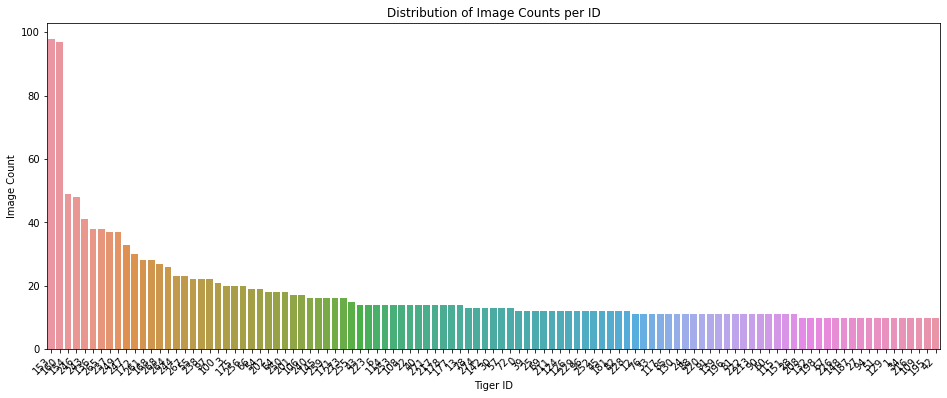

In [2]:
# Visualize the distribution of image counts per Tiger ID
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the figure
plt.figure(figsize=(16, 6))

# Create a countplot using Seaborn
sns.countplot(x='id', data=df, order=df['id'].value_counts().index)
plt.xticks(rotation=45, ha='right')

# Set the title and labels for the plot
plt.title('Distribution of Image Counts per ID')
plt.xlabel('Tiger ID')
plt.ylabel('Image Count')

# Show the plot
plt.show()

### Test (Query images) = minimum 2 images per tiger

In [3]:
import os
import random
import shutil

# Define directories
train_dir = 'reid_data/train/'
test_dir = 'reid_data/test/'
annotation_file = 'reid_data/train/reid_train.csv'
test_annotation_file = 'reid_data/test/reid_test.csv'

# Create test directory if it doesn't exist
os.makedirs(test_dir, exist_ok=True)

# Load the original annotation file
df = pd.read_csv(annotation_file)

# Count the number of images per tiger ID
image_counts = df['id'].value_counts().reset_index()
image_counts.columns = ['id', 'image_count']

# Prepare a list for new annotations and a set to track moved images
new_annotations = []
moved_image_files = set()  # To track files being moved

# Process each tiger ID based on their image count
for _, row in image_counts.iterrows():
    tiger_id = row['id']
    count = row['image_count']
    
    # Get the filenames for this tiger ID
    file_names = df[df['id'] == tiger_id]['file_name'].values
    
    # Determine how many images to select based on the count
    if count < 20:
        num_to_select = 2
    elif 20 <= count < 40:
        num_to_select = 4
    elif 40 <= count < 60:
        num_to_select = 8
    elif 60 <= count < 80:
        num_to_select = 14
    elif 80 <= count < 100:
        num_to_select = 22
    else:
        continue

    # Randomly select the specified number of images
    selected_images = random.sample(list(file_names), min(num_to_select, len(file_names)))

    # Move images and collect new annotations
    for img_file in selected_images:
        # Move the image to the test directory
        src_path = os.path.join(train_dir, img_file)
        dst_path = os.path.join(test_dir, img_file)
        shutil.move(src_path, dst_path)
        
        # Add to new annotations list and track moved files
        new_annotations.append({'id': tiger_id, 'file_name': img_file})
        moved_image_files.add(img_file)  # Track the moved image file

# Create a DataFrame for new annotations
new_annotations_df = pd.DataFrame(new_annotations)

# Save the new annotation file for test images
new_annotations_df.to_csv(test_annotation_file, index=False)

# Remove the moved images from the original DataFrame
df = df[~df['file_name'].isin(moved_image_files)]

# Save the updated original annotation file
df.to_csv(annotation_file, index=False)

# Display the results
print(f"Moved {len(new_annotations)} images to the test folder.")
print("New annotations saved to:", test_annotation_file)
print("Updated original annotations saved to:", annotation_file)

Moved 310 images to the test folder.
New annotations saved to: reid_data/test/reid_test.csv
Updated original annotations saved to: reid_data/train/reid_train.csv


In [10]:
# Define file paths
train_annotation_file = 'reid_data/train/reid_train.csv'
test_annotation_file = 'reid_data/test/reid_test.csv'

# Load the original training data and the test data
train_df = pd.read_csv(train_annotation_file)
test_df = pd.read_csv(test_annotation_file)

# Function to explore dataset
def explore_dataset(df, dataset_name):
    print(f"--- {dataset_name} Dataset ---")
    
    # Display the total image count
    total_image_count = df.shape[0]
    print(f"Total number of images: {total_image_count}")

    # Get the number of unique tigers (unique IDs)
    unique_tiger_count = df['id'].nunique()
    print(f"Number of unique tigers: {unique_tiger_count}")

    # Show distribution of the 'id' column
    print("\nDistribution of 'id' column (Top 10 ids by frequency):")
    print(df['id'].value_counts().head(10))

# Explore the train dataset
explore_dataset(train_df, "Train")

print()

# Explore the test dataset
explore_dataset(test_df, "Test")

--- Train Dataset ---
Total number of images: 1577
Number of unique tigers: 107

Distribution of 'id' column (Top 10 ids by frequency):
153    76
160    75
154    41
246    40
265    34
136    34
237    33
249    33
243    33
247    29
Name: id, dtype: int64

--- Test Dataset ---
Total number of images: 310
Number of unique tigers: 107

Distribution of 'id' column (Top 10 ids by frequency):
153    22
160    22
154     8
246     8
243     8
264     4
256     4
175     4
100     4
97      4
Name: id, dtype: int64


### Reference (Gallary images) = about 8 images per tiger, forming the database

The similarities derived from a Siamese network implementation are utilized to rank images in a database of known tiger individuals according to their similarity to a query image (test images). This reference image folder contains distinct images of each tiger (ideally from different angles), enabling reliable comparisons with test images.

In [13]:
# Define directories
train_dir = 'reid_data/train/'
reference_dir = 'reid_data/reference/'
annotation_file = 'reid_data/train/reid_train.csv'
reference_annotation_file = 'reid_data/reference/reid_reference.csv'

# Create reference directory if it doesn't exist
os.makedirs(reference_dir, exist_ok=True)

# Load the original annotation file
df = pd.read_csv(annotation_file)

# Prepare a list for new annotations
new_annotations = []

# Count the number of images per tiger ID
image_counts = df['id'].value_counts().reset_index()
image_counts.columns = ['id', 'image_count']

# Prepare to copy images
for tiger_id in image_counts['id']:
    # Get the filenames for this tiger ID
    file_names = df[df['id'] == tiger_id]['file_name'].values
    
    # Randomly select 8 images or all if less than 8
    selected_images = random.sample(list(file_names), min(8, len(file_names)))

    # Copy images to the reference directory and collect annotations
    for img_file in selected_images:
        src_path = os.path.join(train_dir, img_file)
        dst_path = os.path.join(reference_dir, img_file)
        shutil.copy(src_path, dst_path)

        # Append to new annotations list
        new_annotations.append({'id': tiger_id, 'file_name': img_file})

# Create a DataFrame for new annotations
new_annotations_df = pd.DataFrame(new_annotations)

# Save the new annotation file for reference images
new_annotations_df.to_csv(reference_annotation_file, index=False)

# Display completion message
print(f"Copied images to the reference directory: {reference_dir}")
print(f"New annotations saved to: {reference_annotation_file}")

Copied images to the reference directory: reid_data/reference/
New annotations saved to: reid_data/reference/reid_reference.csv


In [14]:
# Define file paths
train_annotation_file = 'reid_data/train/reid_train.csv'       # Training annotations
test_annotation_file = 'reid_data/test/reid_test.csv'          # Test annotations
reference_annotation_file = 'reid_data/reference/reid_reference.csv'  # Reference annotations

# Load the annotation files into DataFrames
train_df = pd.read_csv(train_annotation_file)
test_df = pd.read_csv(test_annotation_file)
reference_df = pd.read_csv(reference_annotation_file)

# Function to explore dataset
def explore_dataset(df, dataset_name):
    print(f"--- {dataset_name} Dataset ---")
    
    # Display the total image count
    total_image_count = df.shape[0]
    print(f"Total number of images: {total_image_count}")

    # Get the number of unique tigers (unique IDs)
    unique_tiger_count = df['id'].nunique()
    print(f"Number of unique tigers: {unique_tiger_count}")

    # Show distribution of the 'id' column
    print("\nDistribution of 'id' column (Top 10 ids by frequency):")
    print(df['id'].value_counts().head(10))
    print("\n")

# Explore the train dataset
explore_dataset(train_df, "Train")

# Explore the test dataset
explore_dataset(test_df, "Test")

# Explore the reference dataset
explore_dataset(reference_df, "Reference")

--- Train Dataset ---
Total number of images: 1577
Number of unique tigers: 107

Distribution of 'id' column (Top 10 ids by frequency):
153    76
160    75
154    41
246    40
265    34
136    34
237    33
249    33
243    33
247    29
Name: id, dtype: int64


--- Test Dataset ---
Total number of images: 310
Number of unique tigers: 107

Distribution of 'id' column (Top 10 ids by frequency):
153    22
160    22
154     8
246     8
243     8
264     4
256     4
175     4
100     4
97      4
Name: id, dtype: int64


--- Reference Dataset ---
Total number of images: 856
Number of unique tigers: 107

Distribution of 'id' column (Top 10 ids by frequency):
153    8
12     8
60     8
24     8
76     8
85     8
28     8
117    8
88     8
130    8
Name: id, dtype: int64


